# Quasi 2D with cylindrical symmetry

In [53]:
import numpy as np
import scipy.constants as sc
from scipy.fft import fft,ifft,fftfreq
import matplotlib.pyplot as plt
from numpy import linalg as LA
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
import mpl_toolkits.mplot3d as mplot3d
import scipy.special as ss
from scipy.integrate import quad, dblquad
N =801
k = int(N/4)
alpha=np.pad(ss.jnp_zeros(0,N),(1,0),'constant',constant_values=(0)) # zeros of first derivative of zeroth order bessel function 
##starts from n=1 rather than n = 0
J0 = ss.jn_zeros(0,N+2) #zeros of zeroth order bessel function
S = ss.jv(0,alpha[k]*alpha/J0[N+1])**2
S /= ss.jv(0,alpha)**2
S = np.sqrt(1+sum(S)-S[0])
S /= np.abs(ss.jv(0,alpha[k]))/2
C = np.zeros((N+1,N+1))
for i in tqdm_notebook(range(N+1),leave = False):
    for j in range(N+1):
        C[i,j] = ss.jv(0,alpha[i]*alpha[j]/S)
        C[i,j] /= S*np.abs(ss.jv(0,alpha[i]))*np.abs(ss.jv(0,alpha[j]))/2
b = 50
beta = S/(2*np.pi*b)
def F(f,J):
    out = f*b/J
    return out
def G(g,J):
    out = g*beta/J
    return out
def Finv(f,J):
    out = f*J/b
    return out
def Ginv(g,J):
    out = g*J/beta
    return out
def qfht(psi,J):
    out = F(psi,J) #changes variables
    out = np.matmul(C,out)#applies transformation matrix 
    out = Ginv(out,J)
    return out
def iqfht(psi,J):
    out = G(psi,J)
    out = np.matmul(C,out)
    out = Finv(out,J)
    return out


57.11358257277009
40


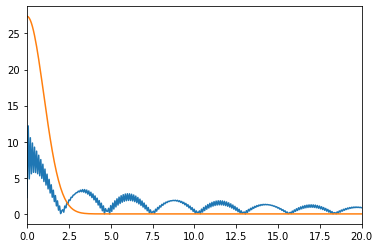

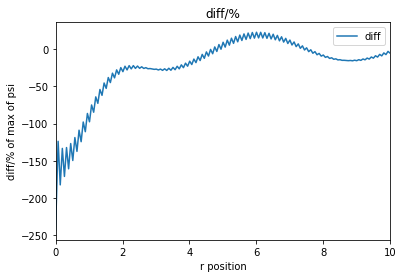

In [60]:
No = 6e3 #number of particles
m = 2.7774e-25
w=100*np.pi
dt = -0.1j/gamma ##has to be very small to account for the spikes in dd_quasi term in fourier space
##increasing b decreases k space, will decrease size of spikes

r = alpha*b/S
rho = alpha*beta/S
J = np.abs(ss.jv(0,alpha))

##for harmonic
xs = np.sqrt(sc.hbar/(m*w))
a = 5.1e-9 
gs = 4*np.pi*a*No/xs #(not g, g in dimensionless units)
g = 4*np.pi*(sc.hbar**2)*a/m

Rc = b+1
mu =6.98
mu_B =9.2740100783e-24
Cdd = sc.mu_0*(mu*mu_B)**2
lamda = (m*No*Cdd)/(3*(sc.hbar**2)*xs) 

# dimensionless variables
gamma = 40
eps = 1/gamma
nz = 1 #polarisation must be cylindrically symmetric so hankel is valid
beta_2D = gs + 2*lamda
beta_2D /= eps*(2*np.pi)**0.5
D = 3*lamda/(4*np.pi) # book keeping for stability
Edd = Cdd/(3*g)

def V(psiq_symm): 
    return 0.5*(r**2) + (beta_2D*np.abs(psiq_symm)**2)/(2*np.pi)

psiq_symm = np.exp(-r**2) ##exponential gives bessel function, not sure why
psiq_symm /= np.sqrt(np.sum(rho*(np.abs(psiq_symm)**2)))    

def dd_quasi_2D_symm(psiq_symm):
    
    out = qfht(np.abs(np.abs(psiq_symm)**2),J) #density in k space
    #out /= np.sum(rho*(np.abs(out)**2))   
    out /= np.sum(rho*(np.abs(out)**2)) ##need to properly normalise
    #out = np.abs(out) #not sure about this
    out *= np.abs(2*np.pi*rho) ## simplified version for n = nz =1
    #out = np.nan_to_num(out)
    out *= -3*lamda/2 
    return out


T = 0.5*(2*np.pi*rho)**2 
def exp_fourier_quasi_2D_symm(psiq_symm):
    #psiq_symm /= LA.norm(psiq_symm)
    return np.exp(-1j*dt*(dd_quasi_2D_symm(psiq_symm)+T))
## for this to not blow up, following inequality must hold
#k_mag>=3*lamda*psi**2 in k space

for i in tqdm_notebook(range(2000),leave = False):
    psiq_symm = np.exp(-0.5j*dt*V(psiq_symm)) * psiq_symm
    psiq_symm = exp_fourier_quasi_2D_symm(psiq_symm)*qfht(psiq_symm,J)/np.sqrt(2*np.pi*np.sum(rho*(np.abs(qfht(psiq_symm,J))**2)))  
    psiq_symm = iqfht(psiq_symm,J)
    #psiq_symm = np.abs(psiq_symm)
    psiq_symm /= np.sqrt(2*np.pi*np.sum(r*(np.abs(psiq_symm)**2)))
    psiq_symm = np.exp(-0.5j*dt*V(psiq_symm)) * psiq_symm
    psiq_symm /= np.sqrt(2*np.pi*np.sum(r*(np.abs(psiq_symm)**2)))

##normalisation within loop might also have to be the proper normalisation    
##it has to be in this order and separated like this to ensure psi 
#is in the right space for the functions
psiq_symm /= np.sqrt(np.sum(r*(np.abs(psiq_symm)**2)))    
psiq_symm *= np.sqrt(No) ## actually should be np.sqrt(No)

#harmonic potential    
gnd_state = np.exp((-r**2)/2)
gnd_state /= np.sqrt(np.sum(r*(np.abs(gnd_state)**2)))    
gnd_state *= np.sqrt(No)
print(D)
print(gamma)

plt.plot(r,np.abs(psiq_symm), label ="numerical ground state")
plt.plot(r,gnd_state, label = "true ground state")
#plt.ylim(-0.01,0.02)
plt.xlim(0,20)
plt.show()
    
diff = psiq_symm-gnd_state
plt.plot(r,100*diff/np.max(psiq_symm),label="diff")
plt.xlabel('r position')
plt.ylabel('diff/% of max of psi')
#plt.ylim(-1,1)
plt.xlim(0,10)
plt.legend()
plt.title('diff/%')
plt.show() # plots psi against x

psiq_symm_r = psiq_symm
    

# Extension to 3D

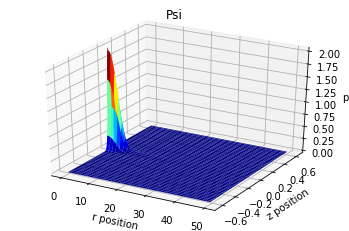

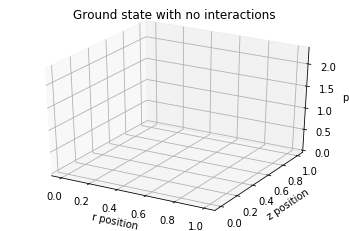

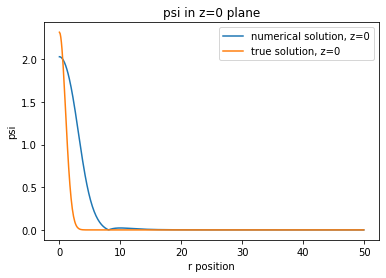

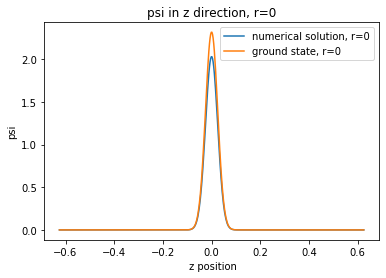

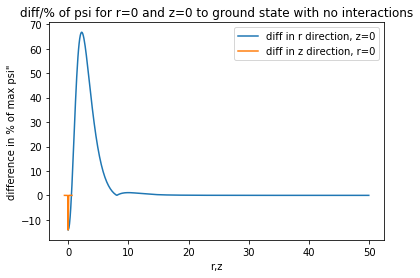

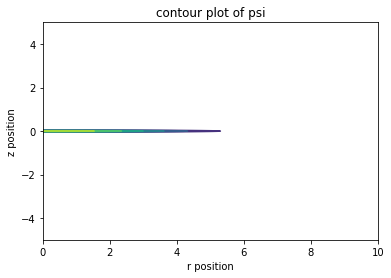

In [45]:
psiq_symm_3D = (psiq_symm_r).reshape(-1,1).repeat(N+1,1)
z = np.linspace(-b/(2*gamma),b/(2*gamma),N+1).reshape(1,-1).repeat(N+1,0)
r_3D = r[:,np.newaxis].repeat(N+1,1)
z_ansatz = np.exp((-(z/eps)**2)/2)
z_ansatz /= (eps**0.5)*(np.pi**0.25)
dz =z[0,0]-z[0,1] 
psiq_symm_3D *= z_ansatz
psiq_symm_3D /= np.sqrt(np.sum(r_3D*(np.abs(psiq_symm_3D)**2)))    
psiq_symm_3D *= np.sqrt(No)

##harmonic ground state
gnd_state = np.exp((-(r_3D**2)/2))*z_ansatz
gnd_state /= np.sqrt(2*np.pi*np.sum(r_3D*(np.abs(gnd_state)**2)))    
gnd_state *= np.sqrt(No)
diff_zr = np.abs(psiq_symm_3D)-np.abs(gnd_state)

midway_index = int((N)/2)
fig=plt.figure()
ax = plt.axes(projection='3d')


z_cutoff = np.max(z)/4
bools = ((np.abs(r) <= 10)*(np.abs(z) <= z_cutoff)).ravel()
bools1 = ((np.abs(r) <= 10)*(np.abs(z) <= z_cutoff)).any(axis = 0)
bools2 = ((np.abs(r) <= 10)*(np.abs(z) <= z_cutoff)).any(axis = 1)
n1,n2 = bools1.sum(),bools2.sum()

# ax.plot_surface(r_3D.ravel()[bools].reshape((n1,n2)),
#                 z.ravel()[bools].reshape((n1,n2)),
#                 np.abs(psiq_symm_3D).ravel()[bools].reshape((n1,n2)),
#                 cmap='jet')
ax.plot_surface(r_3D,z,np.abs(psiq_symm_3D),cmap='jet')
ax.set_title('Psi')
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_zlabel('psi')
plt.show()


ax = plt.axes(projection='3d')
ax.plot_surface(r_3D.ravel()[bools].reshape((n1,n2)),
                z.ravel()[bools].reshape((n1,n2)),
                np.abs(gnd_state).ravel()[bools].reshape((n1,n2)),
                cmap='jet')

ax.set_title('Ground state with no interactions')
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_zlabel('psi')
ax.set_zlim3d([0,np.max(np.abs(gnd_state))])
plt.show()

plt.plot(r_3D[:,0],np.abs(psiq_symm_3D[:,midway_index]),label="numerical solution, z=0")
plt.plot(r_3D[:,0],gnd_state[:,midway_index],label="true solution, z=0")
plt.title('psi in z=0 plane')
#plt.xlim(0,6)
plt.legend()
plt.xlabel('r position')
plt.ylabel('psi')
plt.show()        

plt.plot(z[0,:],np.abs(psiq_symm_3D[0,:]),label="numerical solution, r=0")
plt.plot(z[0,:],np.abs(gnd_state[0,:]),label = "ground state, r=0")
plt.title('psi in z direction, r=0')
plt.legend()
plt.xlabel(' z position')
plt.ylabel('psi')
plt.show()  

plt.plot(r_3D[:,0],100*diff_zr[:,midway_index]/np.max(psiq_symm_3D),label="diff in r direction, z=0")
plt.plot(z[0,:],100*diff_zr[0,:]/np.max(psiq_symm_3D),label="diff in z direction, r=0")
plt.title('diff/% of psi for r=0 and z=0 to ground state with no interactions')
#plt.xlim(0,6)
plt.xlabel('r,z')
plt.ylabel('difference in % of max psi"')
plt.legend()
plt.show()  

fig,ax = plt.subplots()
ax.contour(r_3D,z,np.abs(psiq_symm_3D))
ax.set_title('contour plot of psi')
ax.set_xlabel('r position')
ax.set_ylabel('z position')
ax.set_xlim([0,10])
ax.set_ylim([-5,5])
plt.show()

In [39]:
b/gamma

1.25